<a href="https://colab.research.google.com/github/550tealeaves/DATA-70500-working-with-data/blob/main/ORIG_TextAnalysisMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analysis with Machine Learning

We'll use some techniques to try to develop a model to classify music reviews by genre.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

In [ ]:
!pip install boilerpy3
from boilerpy3 import extractors

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')    # This is a useful way to remove non-content function words from the data.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import string
import re

!pip install contractions
import contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 15.0 MB/s eta 0:00:00


In [ ]:
wnl = nltk.WordNetLemmatizer()
en_stop_words = set(nltk.corpus.stopwords.words('english'))


Here we define the keywords that we'll use as feature extractors in our model. We define them as sets--the list is inside the **set()** function--so that we don't have to worry about duplicate entries.

In [ ]:
rock_terms = set(['acid', 'arena', 'beat', 'garage', 'glam', 'metal', 'indie', 'prog', 'psychedelic', 'punk', 'surf', 'melody', 'soul', 'peace','heavy','wave','bounce','bulge'])
jazz_terms = set(['avant-garde', 'bebop', 'cool', 'free', 'bop', 'Latin', 'swing', 'improv', 'saxophone', 'trumpet','downtown','blue','boogie', 'woogie','ragtime','ballroom'])
rap_terms = set(['bounce', 'chopped', 'crunk', 'freestyle', 'gangsta', 'g-funk', 'trip', 'turntablism', 'mc', 'dj','hiphop', 'rap', 'battle','crossover','hit','southern','bang','south','beats','bass','snap'])
folk_terms = set(['anti-war', 'protest', 'shanty', 'bluegrass', 'cajun', 'cowboy', 'nashville', 'swamp', 'blues', 'zydeco', 'unplugged','americana','regional','ballads','country', 'appalachia','contra','square','fiddle','banjo','skiffle'])


### Data Acquisition

First, we'll scrape reviews from Pitchfork for the 'rock' category. This section of code uses two **for** loops to get the texts and then to tokenize the contents. We're saving the reviews into a dictionary, keyed by the URL, rather than a list this time.

We're only using lemmas with length greater than 3 to filter out many of the function words. Then we're doing keyword matching for each of the four target categories. We save the contents to a Series for each review and then to a DataFrame for later analysis.

In [ ]:
URLs = [
       'https://pitchfork.com/reviews/albums/david-bowie-changesnowbowie/',
       'https://pitchfork.com/reviews/albums/flat-worms-antarctica/',
       'https://pitchfork.com/reviews/albums/skylar-gudasz-cinema/',
       'https://pitchfork.com/reviews/albums/sir-richard-bishop-oneiric-formulary/',
       'https://pitchfork.com/reviews/albums/talking-heads-fear-of-music/',
       'https://pitchfork.com/reviews/albums/talking-heads-talking-heads-77/',
       'https://pitchfork.com/reviews/albums/talking-heads-more-songs-about-buildings-and-food/',
       'https://pitchfork.com/reviews/albums/talking-heads-speaking-in-tongues/',
       'https://pitchfork.com/reviews/albums/talking-heads-little-creatures/',
       'https://pitchfork.com/reviews/albums/the-howling-hex-knuckleball-express/',
       'https://pitchfork.com/reviews/albums/stay-inside-viewing/',
       'https://pitchfork.com/reviews/albums/fiona-apple-fetch-the-bolt-cutters/',
       'https://pitchfork.com/reviews/albums/ambar-lucid-garden-of-lucid/',
       'https://pitchfork.com/reviews/albums/active-child-in-another-life/',
       'https://pitchfork.com/reviews/albums/the-mountain-goats-songs-for-pierre-chuvin/',
       'https://pitchfork.com/reviews/albums/ellis-born-again/',
       'https://pitchfork.com/reviews/albums/hamilton-leithauser-the-loves-of-your-life/',
       'https://pitchfork.com/reviews/albums/trace-mountains-lost-in-the-country/',
       'https://pitchfork.com/reviews/albums/m-ward-migration-stories/',
       'https://pitchfork.com/reviews/albums/joni-mitchell-shine/',
       'https://pitchfork.com/reviews/albums/the-strokes-the-new-abnormal/',
       'https://pitchfork.com/reviews/albums/nick-hakim-will-this-make-me-good/',
       'https://pitchfork.com/reviews/albums/im-glad-its-you-every-sun-every-moon/',
       'https://pitchfork.com/reviews/albums/moses-sumney-grae/',
       'https://pitchfork.com/reviews/albums/damien-jurado-whats-new-tomboy/',
       'https://pitchfork.com/reviews/albums/cafe-racer-shadow-talk/',
       'https://pitchfork.com/reviews/albums/chicano-batman-invisible-people/',
       'https://pitchfork.com/reviews/albums/midwife-forever/',
       'https://pitchfork.com/reviews/albums/pure-x-pure-x/',
       'https://pitchfork.com/reviews/albums/elliott-smith-elliott-smith/',
       'https://pitchfork.com/reviews/albums/retirement-party-runaway-dog/',
       'https://pitchfork.com/reviews/albums/christian-lee-hutson-beginners/',
       'https://pitchfork.com/reviews/albums/nation-of-language-introduction-presence/',
       'https://pitchfork.com/reviews/albums/jeff-rosenstock-no-dream/',
       'https://pitchfork.com/reviews/albums/woods-strange-to-explain/',
       'https://pitchfork.com/reviews/albums/wares-survival/'
]

rock_reviews = {}
for URL in URLs:
    try:
        extractor = extractors.ArticleExtractor()
        rock_reviews[URL] = str(extractor.get_content_from_url(URL)).replace('\n', ' ')

    except:
        print("Can not open " + URL + ".")

rock_df = pd.DataFrame()

rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0
for review in rock_reviews.values():
    rock_tokens = nltk.word_tokenize(review)
    token_size = np.mean([len(t) for t in rock_tokens])
    rock_tokens2 = [t.lower() for t in rock_tokens if t not in en_stop_words]
    rock_lemma = [wnl.lemmatize(t) for t in rock_tokens2]
    rock_vocab = set(rock_lemma)
    for lemma in rock_vocab:
        for term in rock_terms:
            if lemma.find(term) != -1: rock_keywords += 1
        for term in jazz_terms:
            if lemma.find(term) != -1: jazz_keywords += 1
        for term in rap_terms:
            if lemma.find(term) != -1: rap_keywords += 1
        for term in folk_terms:
            if lemma.find(term) != -1: folk_keywords += 1

    rock_freq = nltk.FreqDist(rock_lemma)
    rock_ser = pd.Series([rock_keywords, jazz_keywords, rap_keywords, folk_keywords,
                          len(rock_vocab), len(rock_vocab)/len(rock_lemma),
                          len(rock_freq.hapaxes()), token_size, 'rock'], index = ['rock_keywords',
                                                                      'jazz_keywords', 'rap_keywords',
                                                                      'folk_keywords', 'vocab_size',
                                                                      'lexical_diversity',
                                                                      'number_hapaxes', 'ave word length', 'genre'])
    rock_df = rock_df.append(rock_ser, ignore_index=True)
    rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0


rock_df

<ipython-input-7-1b0c216f056d>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rock_df = rock_df.append(rock_ser, ignore_index=True)
<ipython-input-7-1b0c216f056d>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rock_df = rock_df.append(rock_ser, ignore_index=True)
<ipython-input-7-1b0c216f056d>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rock_df = rock_df.append(rock_ser, ignore_index=True)
<ipython-input-7-1b0c216f056d>:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rock_df = rock_df.append(rock_ser, ignore_index=True)
<ipython-input-7-1b0c216f056d>:76: FutureWarning: The frame.append method is deprecated and will be remo

,rock_keywords,jazz_keywords,rap_keywords,folk_keywords,vocab_size,lexical_diversity,number_hapaxes,ave word length,genre
0,1,0,7,2,328,0.652087,282,4.454305,rock
1,3,0,3,0,287,0.689904,250,4.194872,rock
2,2,1,2,1,314,0.636917,273,4.095109,rock
3,1,2,1,0,357,0.673585,310,4.377863,rock
4,3,1,5,1,670,0.516577,528,4.025411,rock
5,1,5,2,1,455,0.629322,387,4.283528,rock
6,7,0,6,1,442,0.602180,361,4.147738,rock
7,4,1,6,0,487,0.643329,407,4.447898,rock
8,5,2,7,1,583,0.496170,454,4.032583,rock
9,4,2,2,2,299,0.668904,264,4.608964,rock


In [ ]:
rock_corpus = []

for review in rock_reviews.values():
    sentences = nltk.sent_tokenize(review)
    rock_review = ''.join(sentences)
    rock_corpus.append(rock_review)

print(len(rock_corpus))

36


In [ ]:
rock_corpus

['Pinterest David Bowie ’s first greatest-hits set was called Changesonebowie , and the title has proven irresistible to his compilers: That collection was followed by 1981’s Changestwobowie, 1990’s Changesbowie, and 1997’s radio special ChangesNowBowie.Interspersing clips of a long interview with Mary Anne Hobbs with exclusive performances recorded during November 1996 rehearsals for his 50th-birthday concert at Madison Square Garden, ChangesNowBowie originally aired on BBC Radio 1 the week of Bowie’s birthday.Bowie was feeling valedictory at the time, a mood that came through in both the musing interviews and the laid-back performances, backed only by guitarist Reeves Gabrels, bassist/vocalist Gail Ann Dorsey, and keyboardist Mark Plati.The Hobbs-hosted show circulated intact on bootlegs for years, and the official LP was initially slated as a Record Store Day 2020 exclusive.Thanks to COVID-19, the physical release was pushed back, but the digital version is here, and the sanctioned 

In [ ]:
vectorizer = CountVectorizer(
    min_df=10,
    max_df=100,
    stop_words='english',
    ngram_range=(1,2)
    )


In [ ]:

rock_tm = vectorizer.fit_transform(rock_corpus)

rock_feature_names = vectorizer.get_feature_names_out()

rock_dtm = pd.DataFrame(rock_tm.todense(), columns=rock_feature_names)
rock_dtm.head()

,10,affiliate,affiliate links,album,albums,away,band,bassist,best,better,...,voice,want,way,week,words,work,world,writing,year,years
0,0,1,1,2,1,0,0,1,0,0,...,0,1,0,1,0,0,2,0,0,2
1,2,1,1,4,1,0,1,1,2,0,...,0,0,0,1,1,0,0,0,1,1
2,2,0,0,2,1,1,1,0,2,0,...,2,1,1,1,0,0,0,0,0,0
3,0,0,0,4,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,1,1,6,0,4,8,0,2,1,...,3,0,1,0,2,1,1,1,0,0


In [ ]:
rock_tokens_present = np.where(rock_dtm.max() > 1 , True, False)
rocktokenslimited_df = rock_dtm.loc[:, rock_tokens_present]
nullwords = ["pinterest", "copyright", "pitchfork", "affiliate", "ve", "re", "10"]
for term in nullwords:
    rocktokenslimited_df = rocktokenslimited_df.drop(columns=[i for i in list(rocktokenslimited_df.columns) if term in i])
rocktokenslimited_df['genre'] = 0
rocktokenslimited_df

,album,albums,away,band,best,better,big,chorus,city,day,...,voice,want,way,words,work,world,writing,year,years,genre
0,2,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,2,0,0,2,0
1,4,1,0,1,2,0,0,0,1,1,...,0,0,0,1,0,0,0,1,1,0
2,2,1,1,1,2,0,0,0,0,0,...,2,1,1,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,0
4,6,0,4,8,2,1,2,0,3,0,...,3,0,1,2,1,1,1,0,0,0
5,2,1,0,4,0,0,1,0,2,0,...,0,0,3,1,1,0,0,1,2,0
6,5,0,0,2,0,0,5,2,2,1,...,0,1,1,0,1,0,0,0,0,0
7,5,0,0,0,0,1,1,1,0,0,...,0,0,2,0,1,0,0,0,1,0
8,11,1,1,7,2,0,1,2,0,1,...,0,0,1,0,0,0,1,0,3,0
9,2,0,0,2,3,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0


Now, the 'jazz' category.

In [ ]:
URLs = [
       'https://pitchfork.com/reviews/albums/tom-misch-yussef-dayes-what-kinda-music/',
       'https://pitchfork.com/reviews/albums/pharoah-sanders-live-in-paris-1975/',
       'https://pitchfork.com/reviews/albums/shabaka-and-the-ancestors-we-are-sent-here-by-history/',
       'https://pitchfork.com/reviews/albums/sam-gendel-satin-doll/',
       'https://pitchfork.com/reviews/albums/kassa-overall-i-think-im-good/',
       'https://pitchfork.com/reviews/albums/jeremy-cunningham-the-weather-up-there/',
       'https://pitchfork.com/reviews/albums/gil-scott-heron-makaya-mccraven-were-new-again-a-reimagining-by-makaya-mccraven/',
       'https://pitchfork.com/reviews/albums/jeff-parker-suite-for-max-brown/',
       'https://pitchfork.com/reviews/albums/keith-jarrett-munich-2016/',
       'https://pitchfork.com/reviews/albums/dopolarians-garden-party/',
       'https://pitchfork.com/reviews/albums/badge-epoque-ensemble-nature-man-and-woman-ep/',
       'https://pitchfork.com/reviews/albums/junius-paul-ism/',
       'https://pitchfork.com/reviews/albums/jamael-dean-black-space-tapes/',
       'https://pitchfork.com/reviews/albums/tribe-hometown-detroit-sessions-1990-2014/',
       'https://pitchfork.com/reviews/albums/matana-roberts-coin-coin-chapter-four-memphis/',
       'https://pitchfork.com/reviews/albums/jaimie-branch-fly-or-die-ii-bird-dogs-of-paradise/',
       'https://pitchfork.com/reviews/albums/robert-glasper-fuck-yo-feelings/',
       'https://pitchfork.com/reviews/albums/kris-davis-diatom-ribbons/',
       'https://pitchfork.com/reviews/albums/the-comet-is-coming-the-afterlife/',
       'https://pitchfork.com/reviews/albums/tyshawn-sorey-marilyn-crispell-the-adornment-of-time/',
       'https://pitchfork.com/reviews/albums/kamasi-washington-becoming-music-from-the-netflix-original-documentary/',
       'https://pitchfork.com/reviews/albums/archie-shepp-attica-blues/',
       'https://pitchfork.com/reviews/albums/sven-wunder-eastern-flowers/',
       'https://pitchfork.com/reviews/albums/john-coltrane-blue-world/',
       'https://pitchfork.com/reviews/albums/steve-lehman-the-people-i-love/',
       'https://pitchfork.com/reviews/albums/nerija-blume/',
       'https://pitchfork.com/reviews/albums/de-lorians-de-lorians/',
       'https://pitchfork.com/reviews/albums/resavoir-resavoir/',
       'https://pitchfork.com/reviews/albums/miles-davis-the-complete-birth-of-the-cool/',
       'https://pitchfork.com/reviews/albums/fabian-almazan-this-land-abounds-with-life/',
       'https://pitchfork.com/reviews/albums/the-mattson-2-paradise/',
       'https://pitchfork.com/reviews/albums/masayuki-takayanagi-new-direction-unit-april-is-the-cruellest-month/',
       'https://pitchfork.com/reviews/albums/don-cherry-brown-rice/',
       'https://pitchfork.com/reviews/albums/joel-ross-kingmaker/',
       'https://pitchfork.com/reviews/albums/bennie-maupin-the-jewel-in-the-lotus/',
       'https://pitchfork.com/reviews/albums/ray-charles-modern-sounds-in-country-and-western-music-volumes-1-and-2/',
       'https://pitchfork.com/reviews/albums/wadada-leo-smith-rosa-parks-pure-love-an-oratorio-of-seven-songs/',
       'https://pitchfork.com/reviews/albums/theon-cross-fyah/',
       'https://pitchfork.com/reviews/albums/angel-bat-dawid-the-oracle/',
       'https://pitchfork.com/reviews/albums/alice-coltrane-journey-in-satchidananda/',
       'https://pitchfork.com/reviews/albums/eric-dolphy-musical-prophet-the-expanded-1963-new-york-studio-sessions/',
       'https://pitchfork.com/reviews/albums/jeff-goldblum-and-the-mildred-snitzer-orch-the-capitol-studio-sessions/',
       'https://pitchfork.com/reviews/albums/joseph-shabason-anne/'
]

jazz_reviews = {}
for URL in URLs:
    try:
        extractor = extractors.ArticleExtractor()
        jazz_reviews[URL] = str(extractor.get_content_from_url(URL)).replace('\n', ' ')

    except:
        print("Can not open " + URL + ".")
jazz_df = pd.DataFrame()

rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0
for review in jazz_reviews.values():
    jazz_tokens = nltk.word_tokenize(review)
    token_size = np.mean([len(t) for t in jazz_tokens])
    jazz_tokens2 = [t.lower() for t in jazz_tokens if t not in en_stop_words]
    jazz_lemma = [wnl.lemmatize(t) for t in jazz_tokens2]
    jazz_vocab = set(jazz_lemma)
    for lemma in jazz_vocab:
        for term in rock_terms:
            if lemma.find(term) != -1: rock_keywords += 1
        for term in jazz_terms:
            if lemma.find(term) != -1: jazz_keywords += 1
        for term in rap_terms:
            if lemma.find(term) != -1: rap_keywords += 1
        for term in folk_terms:
            if lemma.find(term) != -1: folk_keywords += 1
    jazz_freq = nltk.FreqDist(jazz_lemma)
    jazz_ser = pd.Series([rock_keywords, jazz_keywords, rap_keywords, folk_keywords,
                          len(jazz_vocab), len(jazz_vocab)/len(jazz_lemma),
                          len(jazz_freq.hapaxes()), token_size, 'jazz'], index = ['rock_keywords', 'jazz_keywords',
                                                                      'rap_keywords', 'folk_keywords',
                                                                      'vocab_size', 'lexical_diversity',
                                                                      'number_hapaxes', 'ave word length', 'genre'])
    jazz_df = jazz_df.append(jazz_ser, ignore_index=True)
    rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0

jazz_df

<ipython-input-13-b2cb289dffc5>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jazz_df = jazz_df.append(jazz_ser, ignore_index=True)
<ipython-input-13-b2cb289dffc5>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jazz_df = jazz_df.append(jazz_ser, ignore_index=True)
<ipython-input-13-b2cb289dffc5>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jazz_df = jazz_df.append(jazz_ser, ignore_index=True)
<ipython-input-13-b2cb289dffc5>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jazz_df = jazz_df.append(jazz_ser, ignore_index=True)
<ipython-input-13-b2cb289dffc5>:80: FutureWarning: The frame.append method is deprecated and will be

,rock_keywords,jazz_keywords,rap_keywords,folk_keywords,vocab_size,lexical_diversity,number_hapaxes,ave word length,genre
0,2,1,3,0,226,0.607527,183,4.377143,jazz
1,4,2,2,1,431,0.617479,345,4.165593,jazz
2,0,0,4,0,423,0.619327,353,4.272986,jazz
3,1,3,9,1,301,0.695150,254,4.503413,jazz
4,4,2,12,0,538,0.600446,443,4.393098,jazz
5,1,3,2,1,351,0.662264,297,4.431322,jazz
6,3,3,4,2,578,0.533210,449,4.116931,jazz
7,5,3,5,0,448,0.598131,358,4.218723,jazz
8,0,4,4,0,315,0.648148,269,4.260292,jazz
9,2,5,3,0,294,0.630901,242,4.416901,jazz


In [ ]:
jazz_corpus = []

for review in jazz_reviews.values():
    sentences = nltk.sent_tokenize(review)
    jazz_review = ''.join(sentences)
    jazz_corpus.append(jazz_review)

print(len(jazz_corpus))

43


In [ ]:
vectorizer = CountVectorizer(
    min_df=10,
    max_df=100,
    stop_words='english',
    ngram_range=(1,2)
    )


In [ ]:

jazz_tm = vectorizer.fit_transform(jazz_corpus)

jazz_feature_names = vectorizer.get_feature_names_out()

jazz_dtm = pd.DataFrame(jazz_tm.todense(), columns=jazz_feature_names)
jazz_dtm.head()

,10,10 best,10 hear,1960s,affiliate,affiliate links,album,albums,albums week,alongside,...,voice,way,week,week sign,work,working,world,year,years,york
0,0,0,0,0,1,1,4,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,1,2,0,1,...,1,0,0,0,1,0,1,0,2,0
2,2,1,1,1,1,1,3,1,1,0,...,0,0,1,1,1,0,2,0,0,0
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,2,0,0,0,2,0
4,0,0,0,0,1,1,5,1,0,1,...,0,1,0,0,1,0,2,1,0,1


In [ ]:
jazz_tokens_present = np.where(jazz_dtm.max() > 1 , True, False)
jazztokenslimited_df = jazz_dtm.loc[:, jazz_tokens_present]
nullwords = ["pinterest", "copyright", "pitchfork", "affiliate", "ve", "re"]
for term in nullwords:
    jazztokenslimited_df = jazztokenslimited_df.drop(columns=[i for i in list(jazztokenslimited_df.columns) if term in i])
jazztokenslimited_df['genre'] = 1
jazztokenslimited_df

,10,album,albums,band,bandleader,bass,bassist,best,black,blues,...,vocals,voice,way,work,working,world,year,years,york,genre
0,0,4,0,0,0,0,1,2,0,0,...,3,0,0,1,0,0,0,0,0,1
1,0,1,2,2,0,1,0,1,0,0,...,1,1,0,1,0,1,0,2,0,1
2,2,3,1,0,0,1,0,1,0,0,...,0,0,0,1,0,2,0,0,0,1
3,0,0,0,0,0,2,1,0,0,0,...,1,0,0,2,0,0,0,2,0,1
4,0,5,1,1,0,0,0,1,2,1,...,1,0,1,1,0,2,1,0,1,1
5,2,4,1,0,1,0,0,2,0,0,...,0,1,1,0,0,1,0,0,0,1
6,0,8,2,0,0,1,0,1,4,3,...,0,1,2,3,1,3,1,3,1,1
7,1,4,0,0,2,0,0,2,0,0,...,1,0,2,3,0,2,0,2,0,1
8,0,1,0,0,0,1,0,0,0,3,...,0,0,1,1,0,0,0,0,0,1
9,2,3,1,3,0,0,1,2,0,0,...,1,1,0,0,0,0,0,0,0,1


Next is the 'rap' category.

In [ ]:
URLs = [
       'https://pitchfork.com/reviews/albums/trouble-thug-luv/',
       'https://pitchfork.com/reviews/albums/youngboy-never-broke-again-38-baby-2/',
       'https://pitchfork.com/reviews/albums/chucky73-fetti031-sie7etr3-ep/',
       'https://pitchfork.com/reviews/albums/asher-roth-flowers-on-the-weekend/',
       'https://pitchfork.com/reviews/albums/zeroh-blqlyte/',
       'https://pitchfork.com/reviews/albums/quelle-chris-innocent-country-2/',
       'https://pitchfork.com/reviews/albums/serengeti-ajai/',
       'https://pitchfork.com/reviews/albums/westside-gunn-pray-for-paris/',
       'https://pitchfork.com/reviews/albums/dababy-blame-it-on-baby/',
       'https://pitchfork.com/reviews/albums/shabazz-palaces-the-don-of-diamond-dreams/',
       'https://pitchfork.com/reviews/albums/pink-siifu-negro/',
       'https://pitchfork.com/reviews/albums/22gz-growth-and-development/',
       'https://pitchfork.com/reviews/albums/ghostie-self-hate-wraith/',
       'https://pitchfork.com/reviews/albums/rod-wave-pray-4-love/',
       'https://pitchfork.com/reviews/albums/knxwledge-1988/',
       'https://pitchfork.com/reviews/albums/bankroll-fresh-in-bank-we-trust/',
       'https://pitchfork.com/reviews/albums/ol-dirty-bastard-return-to-the-36-chambers-the-dirty-version/',
       'https://pitchfork.com/reviews/albums/rio-da-yung-og-city-on-my-back/',
       'https://pitchfork.com/reviews/albums/j-balvin-colores/',
       'https://pitchfork.com/reviews/albums/childish-gambino-31520/',
       'https://pitchfork.com/reviews/albums/zebra-katz-less-is-moor/',
       'https://pitchfork.com/reviews/albums/future-high-off-life/',
       'https://pitchfork.com/reviews/albums/polo-g-the-goat/',
       'https://pitchfork.com/reviews/albums/yung-lean-starz/',
       'https://pitchfork.com/reviews/albums/bad-bunny-las-que-no-iban-a-salir/',
       'https://pitchfork.com/reviews/albums/bishop-nehru-nehruvia-my-disregarded-thoughts/',
       'https://pitchfork.com/reviews/albums/sheff-g-one-and-only/',
       'https://pitchfork.com/reviews/albums/lil-tjay-state-of-emergency/',
       'https://pitchfork.com/reviews/albums/lil-durk-just-cause-yall-waited-2/',
       'https://pitchfork.com/reviews/albums/nav-good-intentions/',
       'https://pitchfork.com/reviews/albums/ka-descendants-of-cain/',
       'https://pitchfork.com/reviews/albums/little-simz-drop-6-ep/',
       'https://pitchfork.com/reviews/albums/mozzy-beyond-bulletproof/',
       'https://pitchfork.com/reviews/albums/clams-casino-instrumental-relics/',
       'https://pitchfork.com/reviews/albums/fivio-foreign-800-bc/',
       'https://pitchfork.com/reviews/albums/drake-dark-lane-demo-tapes/',
       'https://pitchfork.com/reviews/albums/fabolous-ghetto-fabolous/',
       'https://pitchfork.com/reviews/albums/el-alfa-el-androide/',
       'https://pitchfork.com/reviews/albums/medhane-cold-water/',
       'https://pitchfork.com/reviews/albums/gunna-wunna/'
]

rap_reviews = {}
for URL in URLs:
    try:
        extractor = extractors.ArticleExtractor()
        rap_reviews[URL] = str(extractor.get_content_from_url(URL)).replace('\n', ' ')

    except:
        print("Can not open " + URL + ".")

rap_df = pd.DataFrame()

rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0
for review in rap_reviews.values():
    rap_tokens = nltk.word_tokenize(review)
    token_size = np.mean([len(t) for t in rap_tokens])
    rap_tokens2 = [t.lower() for t in rap_tokens if t not in en_stop_words]
    rap_lemma = [wnl.lemmatize(t) for t in rap_tokens2]
    rap_vocab = set(rap_lemma)
    for lemma in rap_vocab:
        for term in rock_terms:
            if lemma.find(term) != -1: rock_keywords += 1
        for term in jazz_terms:
            if lemma.find(term) != -1: jazz_keywords += 1
        for term in rap_terms:
            if lemma.find(term) != -1: rap_keywords += 1
        for term in folk_terms:
            if lemma.find(term) != -1: folk_keywords += 1
    rap_freq = nltk.FreqDist(rap_lemma)
    rap_ser = pd.Series([rock_keywords, jazz_keywords, rap_keywords, folk_keywords,
                         len(rap_vocab), len(rap_vocab)/len(rap_lemma),
                         len(rap_freq.hapaxes()), token_size, 'rap'], index = ['rock_keywords', 'jazz_keywords',
                                                                   'rap_keywords', 'folk_keywords',
                                                                   'vocab_size', 'lexical_diversity',
                                                                   'number_hapaxes', 'ave word length', 'genre'])
    rap_df = rap_df.append(rap_ser, ignore_index=True)
    rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0

rap_df

<ipython-input-18-fa2c8232c7be>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rap_df = rap_df.append(rap_ser, ignore_index=True)
<ipython-input-18-fa2c8232c7be>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rap_df = rap_df.append(rap_ser, ignore_index=True)
<ipython-input-18-fa2c8232c7be>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rap_df = rap_df.append(rap_ser, ignore_index=True)
<ipython-input-18-fa2c8232c7be>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rap_df = rap_df.append(rap_ser, ignore_index=True)
<ipython-input-18-fa2c8232c7be>:78: FutureWarning: The frame.append method is deprecated and will be removed fro

,rock_keywords,jazz_keywords,rap_keywords,folk_keywords,vocab_size,lexical_diversity,number_hapaxes,ave word length,genre
0,3,1,8,0,301,0.600798,253,3.863524,rap
1,0,1,4,0,243,0.594132,197,3.904984,rap
2,3,0,3,0,241,0.651351,199,4.174439,rap
3,0,2,4,1,345,0.628415,296,4.151699,rap
4,3,3,4,0,295,0.684455,259,4.329394,rap
5,2,1,7,1,302,0.627859,252,4.030556,rap
6,3,1,8,0,482,0.616368,410,4.085521,rap
7,2,0,9,0,341,0.636194,291,4.076190,rap
8,1,2,5,0,320,0.588235,282,3.908442,rap
9,0,2,5,0,221,0.669697,186,4.253438,rap


In [ ]:
rap_corpus = []

for review in rap_reviews.values():
    sentences = nltk.sent_tokenize(review)
    rap_review = ''.join(sentences)
    rap_corpus.append(rap_review)

print(len(rap_corpus))

40


In [ ]:
vectorizer = CountVectorizer(
    min_df=10,
    max_df=100,
    stop_words='english',
    ngram_range=(1,2)
    )


In [ ]:

rap_tm = vectorizer.fit_transform(rap_corpus)

rap_feature_names = vectorizer.get_feature_names_out()

rap_dtm = pd.DataFrame(rap_tm.todense(), columns=rap_feature_names)
rap_dtm.head()

,ain,album,albums,away,bad,beat,beats,best,better,called,...,voice,want,way,words,work,world,year,years,york,young
0,1,6,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,2,0,1
1,2,2,0,0,1,0,0,1,1,0,...,1,0,1,0,0,0,2,0,0,0
2,0,0,0,1,1,0,4,0,1,0,...,0,0,0,0,0,1,0,1,2,0
3,0,7,0,1,0,0,0,1,0,0,...,0,1,2,0,0,1,0,0,0,0
4,0,1,1,0,0,1,0,2,0,0,...,0,0,0,0,0,1,1,1,0,0


In [ ]:
rap_tokens_present = np.where(rap_dtm.max() > 1 , True, False)
raptokenslimited_df = rap_dtm.loc[:, rap_tokens_present]
nullwords = ["pinterest", "copyright", "pitchfork", "affiliate", "ve", "re"]
for term in nullwords:
    raptokenslimited_df = raptokenslimited_df.drop(columns=[i for i in list(raptokenslimited_df.columns) if term in i])
raptokenslimited_df['genre'] = 2
raptokenslimited_df

,ain,album,albums,away,bad,beat,beats,best,better,city,...,voice,way,words,work,world,year,years,york,young,genre
0,1,6,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,2,0,1,2
1,2,2,0,0,1,0,0,1,1,0,...,1,1,0,0,0,2,0,0,0,2
2,0,0,0,1,1,0,4,0,1,1,...,0,0,0,0,1,0,1,2,0,2
3,0,7,0,1,0,0,0,1,0,0,...,0,2,0,0,1,0,0,0,0,2
4,0,1,1,0,0,1,0,2,0,0,...,0,0,0,0,1,1,1,0,0,2
5,1,3,0,0,0,1,2,1,0,0,...,2,1,0,0,1,0,0,0,0,2
6,0,2,2,0,1,0,1,0,0,0,...,0,1,0,3,3,1,2,0,2,2
7,0,3,1,0,0,3,1,2,1,1,...,0,0,0,0,0,1,0,1,0,2
8,0,6,0,0,0,1,0,1,0,0,...,3,1,1,0,0,0,0,0,0,2
9,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,3,0,0,2


Last is the 'folk' category.

In [ ]:
URLs = [
       'https://pitchfork.com/reviews/albums/lucinda-williams-good-souls-better-angels/',
       'https://pitchfork.com/reviews/albums/james-elkington-ever-roving-eye/',
       'https://pitchfork.com/reviews/albums/laura-marling-song-for-our-daughter/',
       'https://pitchfork.com/reviews/albums/mosses-tv-sun/',
       'https://pitchfork.com/reviews/albums/sam-hunt-southside/',
       'https://pitchfork.com/reviews/albums/william-tyler-music-from-first-cow/',
       'https://pitchfork.com/reviews/albums/brandy-clark-your-life-is-a-record/',
       'https://pitchfork.com/reviews/albums/katie-pruitt-expectations/',
       'https://pitchfork.com/reviews/albums/john-moreland-lp5/',
       'https://pitchfork.com/reviews/albums/bill-fay-countless-branches/',
       'https://pitchfork.com/reviews/albums/aoife-nessa-frances-land-of-no-junction/',
       'https://pitchfork.com/reviews/albums/loving-if-i-am-only-my-thoughts/',
       'https://pitchfork.com/reviews/albums/terry-allen-and-the-panhandle-mystery-ba-just-like-moby-dick/',
       'https://pitchfork.com/reviews/albums/dixie-chicks-home/',
       'https://pitchfork.com/reviews/albums/string-machine-death-of-the-neon/',
       'https://pitchfork.com/reviews/albums/sarah-mary-chadwick-please-daddy/',
       'https://pitchfork.com/reviews/albums/lina-raul-refree-lina-raul-refree/',
       'https://pitchfork.com/reviews/albums/friendship-dreamin/',
       'https://pitchfork.com/reviews/albums/san-cha-la-luz-de-la-esperanza/',
       'https://pitchfork.com/reviews/albums/grace-cummings-refuge-cove/',
       'https://pitchfork.com/reviews/albums/hurt-valley-glacial-pace/',
       'https://pitchfork.com/reviews/albums/jason-isbell-and-the-400-unit-reunions/',
       'https://pitchfork.com/reviews/albums/johanna-warren-chaotic-good/',
       'https://pitchfork.com/reviews/albums/molly-sarle-karaoke-angel/',
       'https://pitchfork.com/reviews/albums/devendra-banhart-ma/',
       'https://pitchfork.com/reviews/albums/the-highwomen-the-highwomen/',
       'https://pitchfork.com/reviews/albums/patsy-cline-sentimentally-yours/',
       'https://pitchfork.com/reviews/albums/kd-lang-ingenue/',
       'https://pitchfork.com/reviews/albums/boy-scouts-free-company/',
       'https://pitchfork.com/reviews/albums/joan-shelley-like-the-river-loves-the-sea/',
       'https://pitchfork.com/reviews/albums/shannon-lay-august/',
       'https://pitchfork.com/reviews/albums/esther-rose-you-made-it-this-far/',
       'https://pitchfork.com/reviews/albums/lillie-mae-other-girls/',
       'https://pitchfork.com/reviews/albums/marika-hackman-any-human-friend/',
       'https://pitchfork.com/reviews/albums/tyler-childers-country-squire/',
       'https://pitchfork.com/reviews/albums/florist-emily-alone/',
       'https://pitchfork.com/reviews/albums/joanna-sternberg-then-i-try-some-more/',
       'https://pitchfork.com/reviews/albums/daughter-of-swords-dawnbreaker/',
       'https://pitchfork.com/reviews/albums/bedouine-bird-songs-of-a-killjoy/',
       'https://pitchfork.com/reviews/albums/jaime-wyatt-neon-cross/',
       'https://pitchfork.com/reviews/albums/daniel-norgren-wooh-dang/',
       'https://pitchfork.com/reviews/albums/the-tallest-man-on-earth-i-love-you-its-a-fever-dream/',
       'https://pitchfork.com/reviews/albums/bruce-hornsby-absolute-zero/',
       'https://pitchfork.com/reviews/albums/rozi-plain-what-a-boost/',
       'https://pitchfork.com/reviews/albums/maren-morris-girl/',
       'https://pitchfork.com/reviews/albums/sun-kil-moon-i-also-want-to-die-in-new-orleans/'
]

folk_reviews = {}
for URL in URLs:
    try:
        extractor = extractors.ArticleExtractor()
        folk_reviews[URL] = str(extractor.get_content_from_url(URL)).replace('\n', ' ')

    except:
        print("Can not open " + URL + ".")

folk_df = pd.DataFrame()

rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0
for review in folk_reviews.values():
    folk_tokens = nltk.word_tokenize(review)
    token_size = np.mean([len(t) for t in folk_tokens])
    folk_tokens2 = [t.lower() for t in folk_tokens if t not in en_stop_words]
    folk_lemma = [wnl.lemmatize(t) for t in folk_tokens2]
    folk_vocab = set(folk_lemma)
    for lemma in folk_vocab:
        for term in rock_terms:
            if lemma.find(term) != -1: rock_keywords += 1
        for term in jazz_terms:
            if lemma.find(term) != -1: jazz_keywords += 1
        for term in rap_terms:
            if lemma.find(term) != -1: rap_keywords += 1
        for term in folk_terms:
            if lemma.find(term) != -1: folk_keywords += 1
    folk_freq = nltk.FreqDist(folk_lemma)
    folk_ser = pd.Series([rock_keywords, jazz_keywords, rap_keywords, folk_keywords,
                          len(folk_vocab), len(folk_vocab)/len(folk_lemma),
                          len(folk_freq.hapaxes()), token_size, 'folk'], index = ['rock_keywords', 'jazz_keywords',
                                                                      'rap_keywords', 'folk_keywords',
                                                                      'vocab_size', 'lexical_diversity',
                                                                      'number_hapaxes', 'ave word length', 'genre'])
    folk_df = folk_df.append(folk_ser, ignore_index=True)
    rock_keywords = jazz_keywords = rap_keywords = folk_keywords = 0

folk_df


Can not open https://pitchfork.com/reviews/albums/the-tallest-man-on-earth-i-love-you-its-a-fever-dream/.


<ipython-input-23-372d452847b9>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folk_df = folk_df.append(folk_ser, ignore_index=True)
<ipython-input-23-372d452847b9>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folk_df = folk_df.append(folk_ser, ignore_index=True)
<ipython-input-23-372d452847b9>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folk_df = folk_df.append(folk_ser, ignore_index=True)
<ipython-input-23-372d452847b9>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  folk_df = folk_df.append(folk_ser, ignore_index=True)
<ipython-input-23-372d452847b9>:84: FutureWarning: The frame.append method is deprecated and will be

,rock_keywords,jazz_keywords,rap_keywords,folk_keywords,vocab_size,lexical_diversity,number_hapaxes,ave word length,genre
0,5,2,5,5,459,0.616107,397,4.101154,folk
1,3,1,0,0,309,0.613095,264,4.237598,folk
2,4,3,2,1,337,0.590193,281,4.058072,folk
3,5,1,2,0,361,0.662385,317,4.546284,folk
4,3,3,5,7,396,0.618750,332,4.362776,folk
5,0,1,1,5,334,0.669339,281,4.301935,folk
6,0,0,2,2,394,0.602446,329,4.047665,folk
7,1,1,1,2,289,0.701456,249,4.408385,folk
8,4,0,1,2,371,0.626689,324,4.097315,folk
9,3,0,0,1,248,0.632653,208,4.090323,folk


In [ ]:
folk_corpus = []

for review in folk_reviews.values():
    sentences = nltk.sent_tokenize(review)
    folk_review = ''.join(sentences)
    folk_corpus.append(folk_review)

print(len(folk_corpus))

45


In [ ]:
vectorizer = CountVectorizer(
    min_df=10,
    max_df=100,
    stop_words='english',
    ngram_range=(1,2)
    )


In [ ]:
folk_tm = vectorizer.fit_transform(folk_corpus)

folk_feature_names = vectorizer.get_feature_names_out()

folk_dtm = pd.DataFrame(folk_tm.todense(), columns=folk_feature_names)
folk_dtm.head()

,10,10 best,10 hear,2017,acoustic,affiliate,affiliate links,album,albums,albums week,...,woman,word,words,work,world,writing,written,wrote,year,years
0,0,0,0,1,0,1,1,5,0,0,...,1,1,1,1,5,0,0,1,1,1
1,0,0,0,1,2,1,1,2,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,1,1,0,0,6,0,0,...,4,0,1,1,0,0,0,0,0,1
3,2,1,1,0,0,0,0,3,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,7,0,0,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
folk_tokens_present = np.where(folk_dtm.max() > 1 , True, False)
folktokenslimited_df = folk_dtm.loc[:, folk_tokens_present]
nullwords = ["pinterest", "copyright", "pitchfork", "affiliate", "ve", "re"]
for term in nullwords:
    folktokenslimited_df = folktokenslimited_df.drop(columns=[i for i in list(folktokenslimited_df.columns) if term in i])
folktokenslimited_df['genre'] = 3
folktokenslimited_df

,10,acoustic,album,albums,arrangements,artists,away,band,best,better,...,word,words,work,world,writing,written,wrote,year,years,genre
0,0,0,5,0,0,0,0,2,1,1,...,1,1,1,5,0,0,1,1,1,3
1,0,2,2,0,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,3
2,0,1,6,0,0,0,2,2,0,0,...,0,1,1,0,0,0,0,0,1,3
3,2,0,3,1,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,3
4,0,1,7,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3
5,0,0,0,0,0,1,0,0,0,0,...,0,0,3,1,0,0,1,0,1,3
6,0,0,5,1,1,1,0,0,3,0,...,0,1,1,0,0,2,0,1,0,3
7,2,0,3,1,1,0,0,0,1,0,...,0,0,1,0,0,1,1,1,3,3
8,0,1,3,0,0,0,1,0,1,1,...,0,1,0,0,1,0,0,0,1,3
9,1,0,7,1,0,0,0,1,0,0,...,0,0,0,5,1,0,1,0,1,3


We combine the genre DataFrames into a new DataFrame in order to build our model. We're using only the quantitative features for the machine learning classification.

In [ ]:
reviews_df = pd.concat([rock_df, jazz_df, rap_df, folk_df], ignore_index=True)
reviews_df


,rock_keywords,jazz_keywords,rap_keywords,folk_keywords,vocab_size,lexical_diversity,number_hapaxes,ave word length,genre
0,1,0,7,2,328,0.652087,282,4.454305,rock
1,3,0,3,0,287,0.689904,250,4.194872,rock
2,2,1,2,1,314,0.636917,273,4.095109,rock
3,1,2,1,0,357,0.673585,310,4.377863,rock
4,3,1,5,1,670,0.516577,528,4.025411,rock
...,...,...,...,...,...,...,...,...,...
159,1,1,1,2,218,0.612360,182,4.311024,folk
160,2,1,4,3,321,0.655102,264,4.400283,folk
161,4,3,1,2,339,0.642045,292,4.350449,folk
162,0,0,4,4,432,0.555270,358,3.964194,folk


In [ ]:
reviews2_df = pd.concat([rocktokenslimited_df, jazztokenslimited_df, raptokenslimited_df, folktokenslimited_df], ignore_index=True).fillna(0)
reviews2_df


,album,albums,away,band,best,better,big,chorus,city,day,...,sound like,star,strings,times,title track,trying,woman,word,written,wrote
0,2,1,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,1,0.0,1.0,2,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,1.0,1.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.0,0.0,0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0,4.0,8.0,2,1.0,2.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1,1,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
160,5,0,0.0,2.0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
161,2,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,4,0,0.0,0.0,3,1.0,2.0,2.0,0.0,0.0,...,1.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
reviews2_df.info('verbose')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 238 columns):
 #    Column             Dtype  
---   ------             -----  
 0    album              int64  
 1    albums             int64  
 2    away               float64
 3    band               float64
 4    best               int64  
 5    better             float64
 6    big                float64
 7    chorus             float64
 8    city               float64
 9    day                float64
 10   debut              int64  
 11   did                float64
 12   does               float64
 13   doesn              float64
 14   don                float64
 15   drummer            float64
 16   drums              float64
 17   early              float64
 18   end                int64  
 19   far                float64
 20   feel               int64  
 21   feeling            float64
 22   feels              int64  
 23   felt               float64
 24   good               float64
 25

We split the data into two parts, training and testing, using a 67/33 split.

Our first model uses a linear support vector classifier. We can assess the model with the classification report.

In [ ]:
model_data_Y = reviews_df['genre']
model_data_X = reviews_df[['lexical_diversity', 'rock_keywords', 'jazz_keywords', 'rap_keywords', 'folk_keywords', 'ave word length']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

from sklearn.svm import LinearSVC
model0 = LinearSVC(C = 10, max_iter = 10000000).fit(X_train, y_train)
model0_pred = model0.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model0_pred, zero_division = 0))

              precision    recall  f1-score   support

        folk       0.70      0.70      0.70        20
        jazz       0.58      0.50      0.54        14
         rap       0.69      0.92      0.79        12
        rock       0.29      0.22      0.25         9

    accuracy                           0.62        55
   macro avg       0.56      0.58      0.57        55
weighted avg       0.60      0.62      0.60        55



In [ ]:
model_data_Y = reviews2_df['genre']
model_data_X = reviews2_df.drop(['genre'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

from sklearn.svm import LinearSVC
model1 = LinearSVC(C = 10, max_iter = 10000000).fit(X_train, y_train)
model1_pred = model1.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model1_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        20

    accuracy                           0.98        55
   macro avg       0.97      0.98      0.98        55
weighted avg       0.98      0.98      0.98        55



The diagnostics in the classification report tell us different things about the quality of the categorization. Accuracy is a proportion of the correct decisions  to the total number of decisions (number of cases). Precision refers to the ratio of true positives to the sum of true positives and false positives, or how many of the predicted positives are true. This is a good assessment when you want to minimize false positives.  Finally, recall, or sensitivity, is the ratio of true positives to the sum of true positives and false negatives. This is important when you don't want to miss any true positives--that is, to avoid false negatives. The f-score is a harmonic mean of precision and recall.

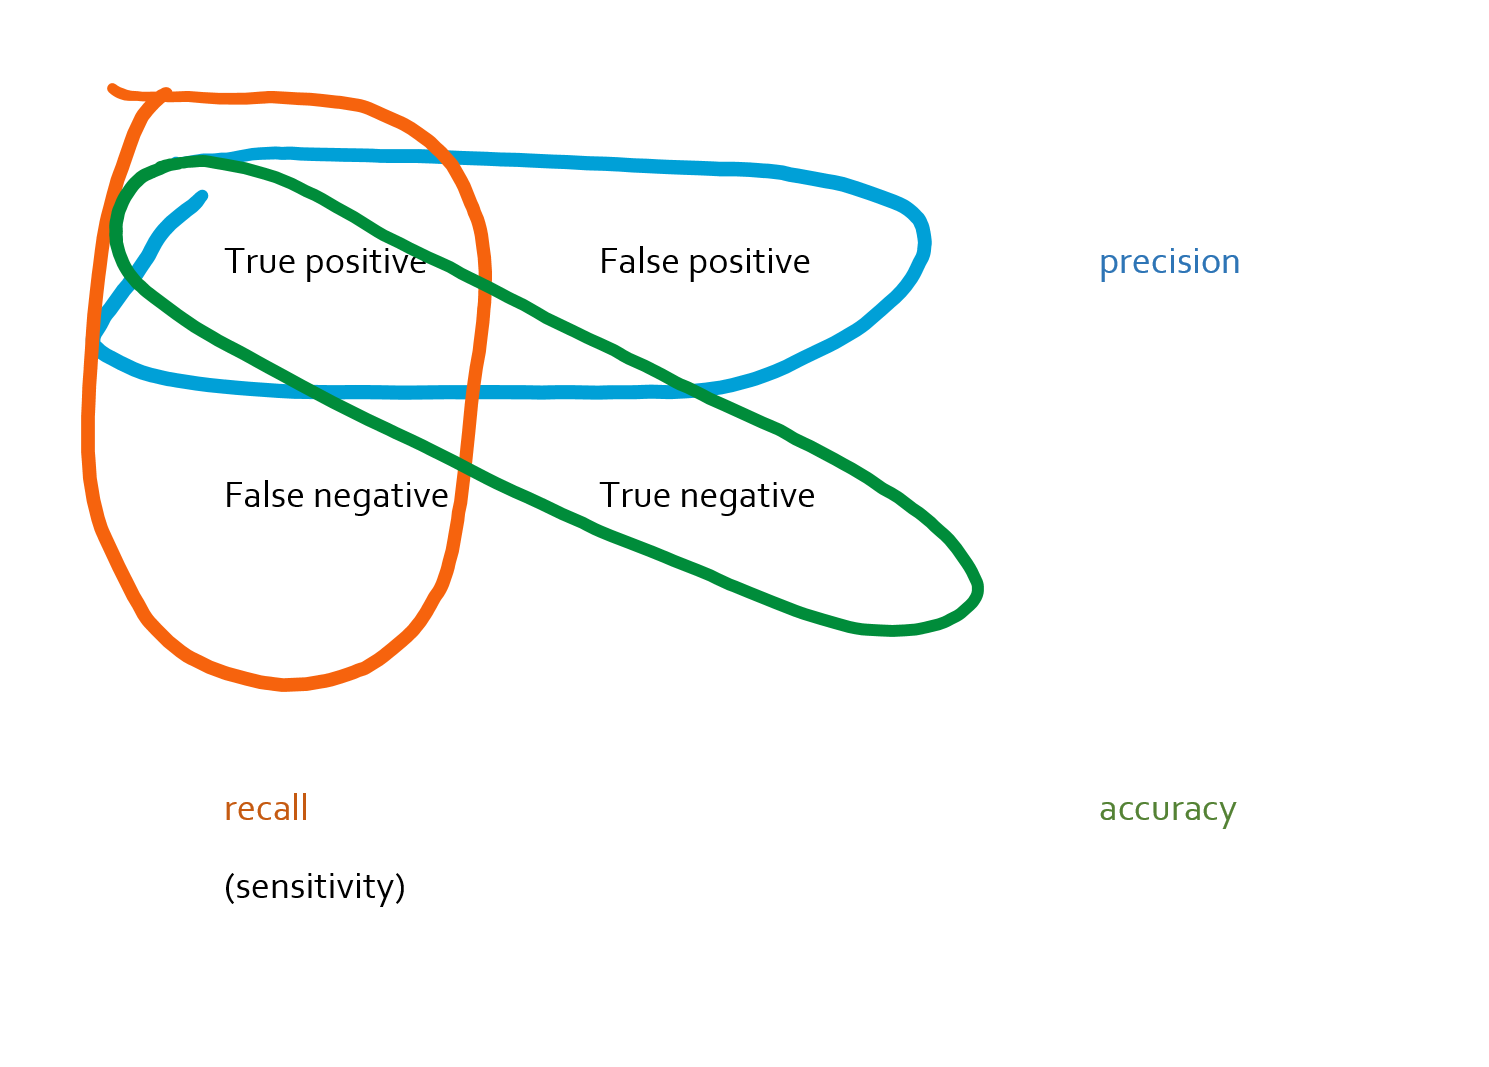

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

model_data_Y = reviews2_df['genre']
model_data_X = reviews2_df.drop(['genre'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    model_data_X, model_data_Y, test_size=0.33, random_state=0
)

model2 = lda(n_components=3).fit(X_train, y_train)
model2_pred = model2.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model2_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      1.00      1.00        14
           2       1.00      0.83      0.91        12
           3       1.00      1.00      1.00        20

    accuracy                           0.96        55
   macro avg       0.95      0.96      0.95        55
weighted avg       0.97      0.96      0.96        55



One potential problem for the classification algorithms is colinearity. We can assess this with the Seaborn heatmap plot. We're looking for correlations among the features close, in magnitude, to 1. The best model will have a small number of orthoginal features. Correlations near zero suggest (near) orthoginality.

<Axes: >

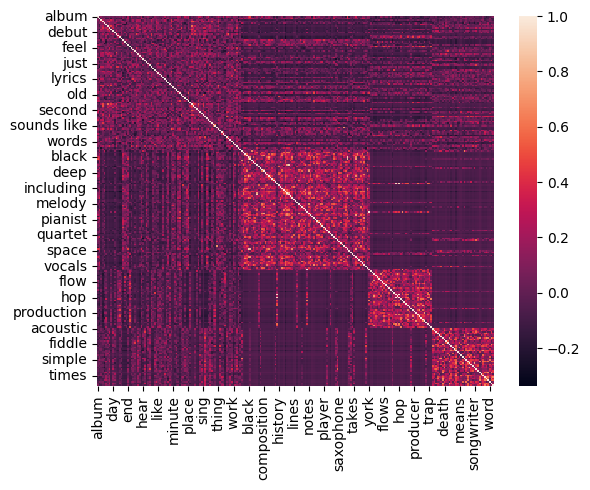

In [ ]:
X_corr = X_train.corr()
sb.heatmap(X_corr)

In [ ]:
reviews_df['is_rock'] = 0
reviews_df.loc[reviews_df.genre == 'rock', ['is_rock']] = 1
reviews_df['is_jazz'] = 0
reviews_df.loc[reviews_df.genre == 'jazz', ['is_jazz']] = 1
reviews_df['is_rap'] = 0
reviews_df.loc[reviews_df.genre == 'rap', ['is_rap']] = 1
reviews_df['is_folk'] = 0
reviews_df.loc[reviews_df.genre == 'folk', ['is_folk']] = 1


In [ ]:
reviews_df['genre_num'] = 0
reviews_df.loc[reviews_df.genre == 'jazz', ['genre_num']] = 1
reviews_df.loc[reviews_df.genre == 'rap', ['genre_num']] = 2
reviews_df.loc[reviews_df.genre == 'folk', ['genre_num']] = 3


In [ ]:
reviews_df['genre_num']


0      0
1      0
2      0
3      0
4      0
      ..
159    3
160    3
161    3
162    3
163    3
Name: genre_num, Length: 164, dtype: int64

In [ ]:
Y = reviews_df['is_rock']
X = reviews_df[['lexical_diversity', 'rock_keywords', 'jazz_keywords', 'rap_keywords', 'folk_keywords', 'ave word length']]
X = sm.add_constant(X)
model3 = sm.Logit(Y, X, missing='drop').fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.449641
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                is_rock   No. Observations:                  164
Model:                          Logit   Df Residuals:                      157
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.1456
Time:                        22:14:51   Log-Likelihood:                -73.741
converged:                       True   LL-Null:                       -86.312
Covariance Type:            nonrobust   LLR p-value:                 0.0003215
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.1055      5.440     -0.755      0.450     -14.767       6.556
lexical_

In [ ]:
model4 = sm.GLM(Y, X, missing='drop', family=sm.families.Gamma()).fit()
print(model4.summary())
print(model4.predict())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                is_rock   No. Observations:                  164
Model:                            GLM   Df Residuals:                      157
Model Family:                   Gamma   Df Model:                            6
Link Function:           InversePower   Scale:                          6.2906
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Mon, 20 Nov 2023   Deviance:                       9280.8
Time:                        22:14:51   Pearson chi2:                     988.
No. Iterations:                    13   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                45.0402     17.44

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1806: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


In [ ]:
model5 = sm.MNLogit(Y, X, missing='drop').fit()
print(model5.summary())


Optimization terminated successfully.
         Current function value: 0.449641
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                is_rock   No. Observations:                  164
Model:                        MNLogit   Df Residuals:                      157
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.1456
Time:                        22:14:51   Log-Likelihood:                -73.741
converged:                       True   LL-Null:                       -86.312
Covariance Type:            nonrobust   LLR p-value:                 0.0003215
        is_rock=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.1055      5.440     -0.755      0.450     -14.767       6.556
lexical_

In [ ]:
Y = reviews_df['is_jazz']
X = reviews_df[['lexical_diversity', 'rock_keywords', 'jazz_keywords', 'rap_keywords', 'folk_keywords', 'ave word length']]
X = sm.add_constant(X)
model6 = sm.Logit(Y, X, missing='drop').fit()
print(model6.summary())

Optimization terminated successfully.
         Current function value: 0.329622
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                is_jazz   No. Observations:                  164
Model:                          Logit   Df Residuals:                      157
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.4271
Time:                        22:14:51   Log-Likelihood:                -54.058
converged:                       True   LL-Null:                       -94.356
Covariance Type:            nonrobust   LLR p-value:                 2.691e-15
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -31.4647      7.701     -4.086      0.000     -46.558     -16.371
lexical_

In [ ]:
Y = reviews_df['is_rap']
X = reviews_df[['lexical_diversity', 'rock_keywords', 'jazz_keywords', 'rap_keywords', 'folk_keywords', 'ave word length']]
X = sm.add_constant(X)
model7 = sm.Logit(Y, X, missing='drop').fit()
print(model7.summary())

Optimization terminated successfully.
         Current function value: 0.215495
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 is_rap   No. Observations:                  164
Model:                          Logit   Df Residuals:                      157
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.6121
Time:                        22:14:51   Log-Likelihood:                -35.341
converged:                       True   LL-Null:                       -91.108
Covariance Type:            nonrobust   LLR p-value:                 9.730e-22
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                42.4155     10.408      4.075      0.000      22.016      62.815
lexical_

In [ ]:
Y = reviews_df['is_folk']
X = reviews_df[['lexical_diversity', 'rock_keywords', 'jazz_keywords', 'rap_keywords', 'folk_keywords',  'ave word length']]
X = sm.add_constant(X)
model9 = sm.Logit(Y, X, missing='drop').fit()
print(model9.summary())

Optimization terminated successfully.
         Current function value: 0.359887
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                is_folk   No. Observations:                  164
Model:                          Logit   Df Residuals:                      157
Method:                           MLE   Df Model:                            6
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.3875
Time:                        22:14:51   Log-Likelihood:                -59.021
converged:                       True   LL-Null:                       -96.363
Covariance Type:            nonrobust   LLR p-value:                 4.462e-14
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.6573      6.371      0.574      0.566      -8.830      16.145
lexical_

In [ ]:
Y = reviews2_df['genre']
X = reviews2_df.drop(['genre'], axis=1)
model12 = lda(n_components=3,store_covariance=True).fit(X, Y).transform(X)


<Figure size 640x480 with 0 Axes>

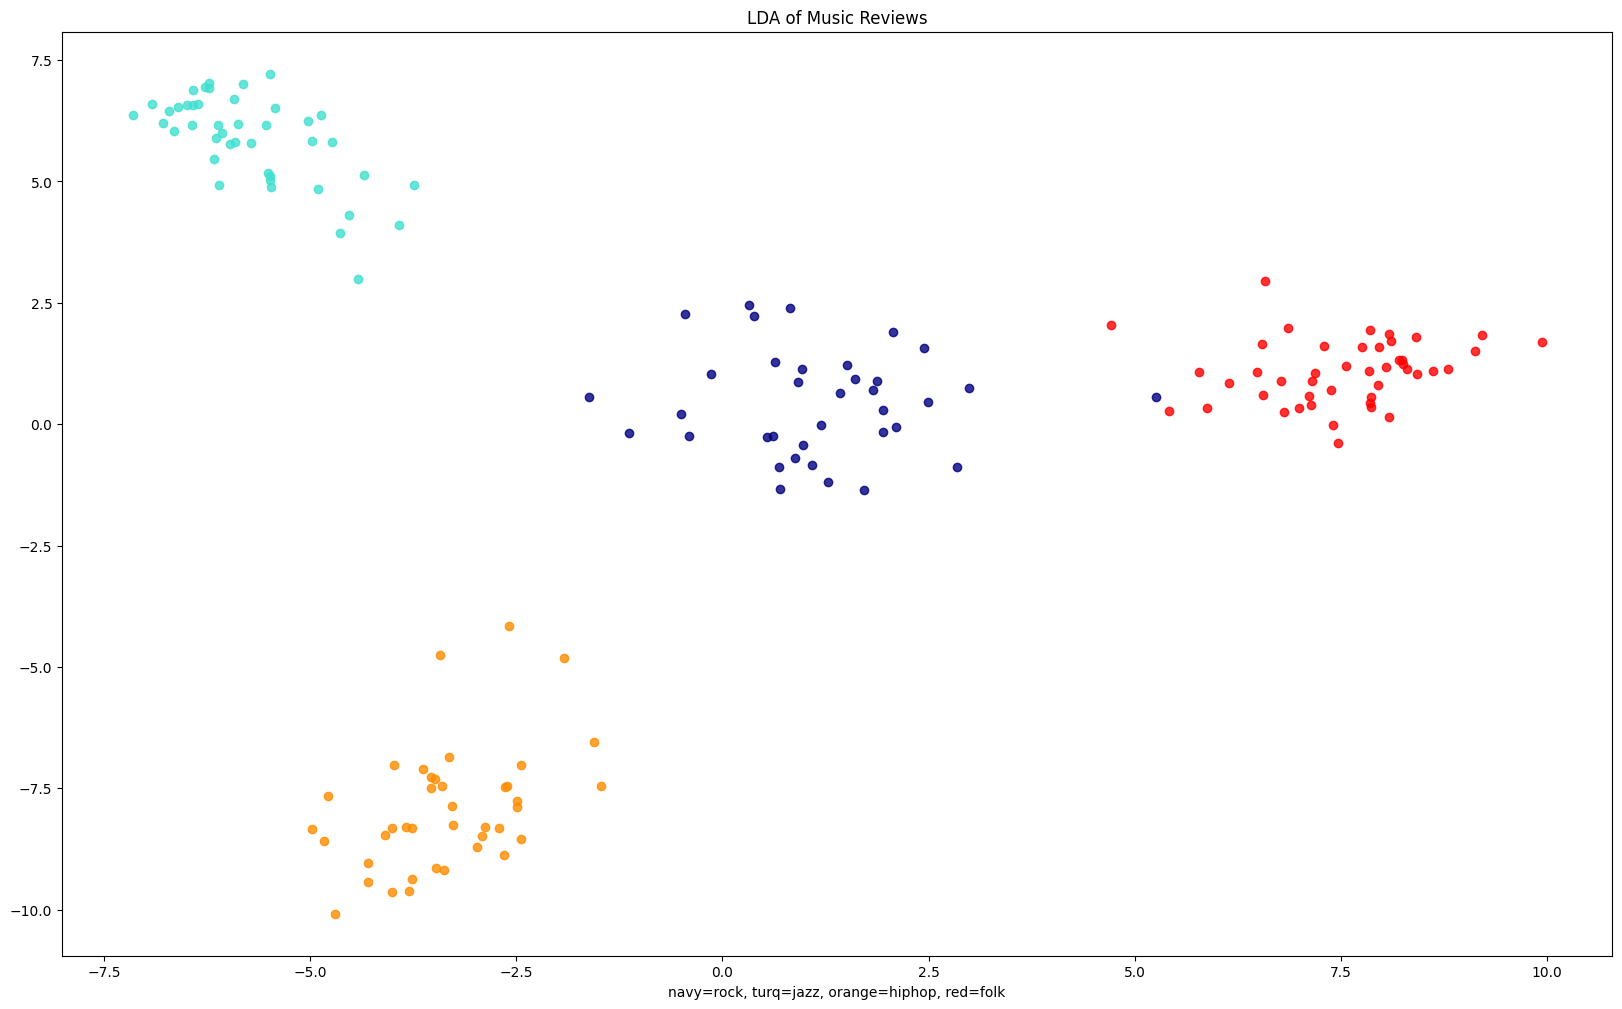

In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'red']
lw = 2

plt.figure(figsize=(20,12))
for color, i in zip(colors, [0, 1, 2, 3]):
    plt.scatter(model12[Y == i, 0], model12[Y == i, 1], alpha=.8, color=color)
plt.title('LDA of Music Reviews')
plt.xlabel('navy=rock, turq=jazz, orange=hiphop, red=folk')

plt.show()

<Figure size 640x480 with 0 Axes>

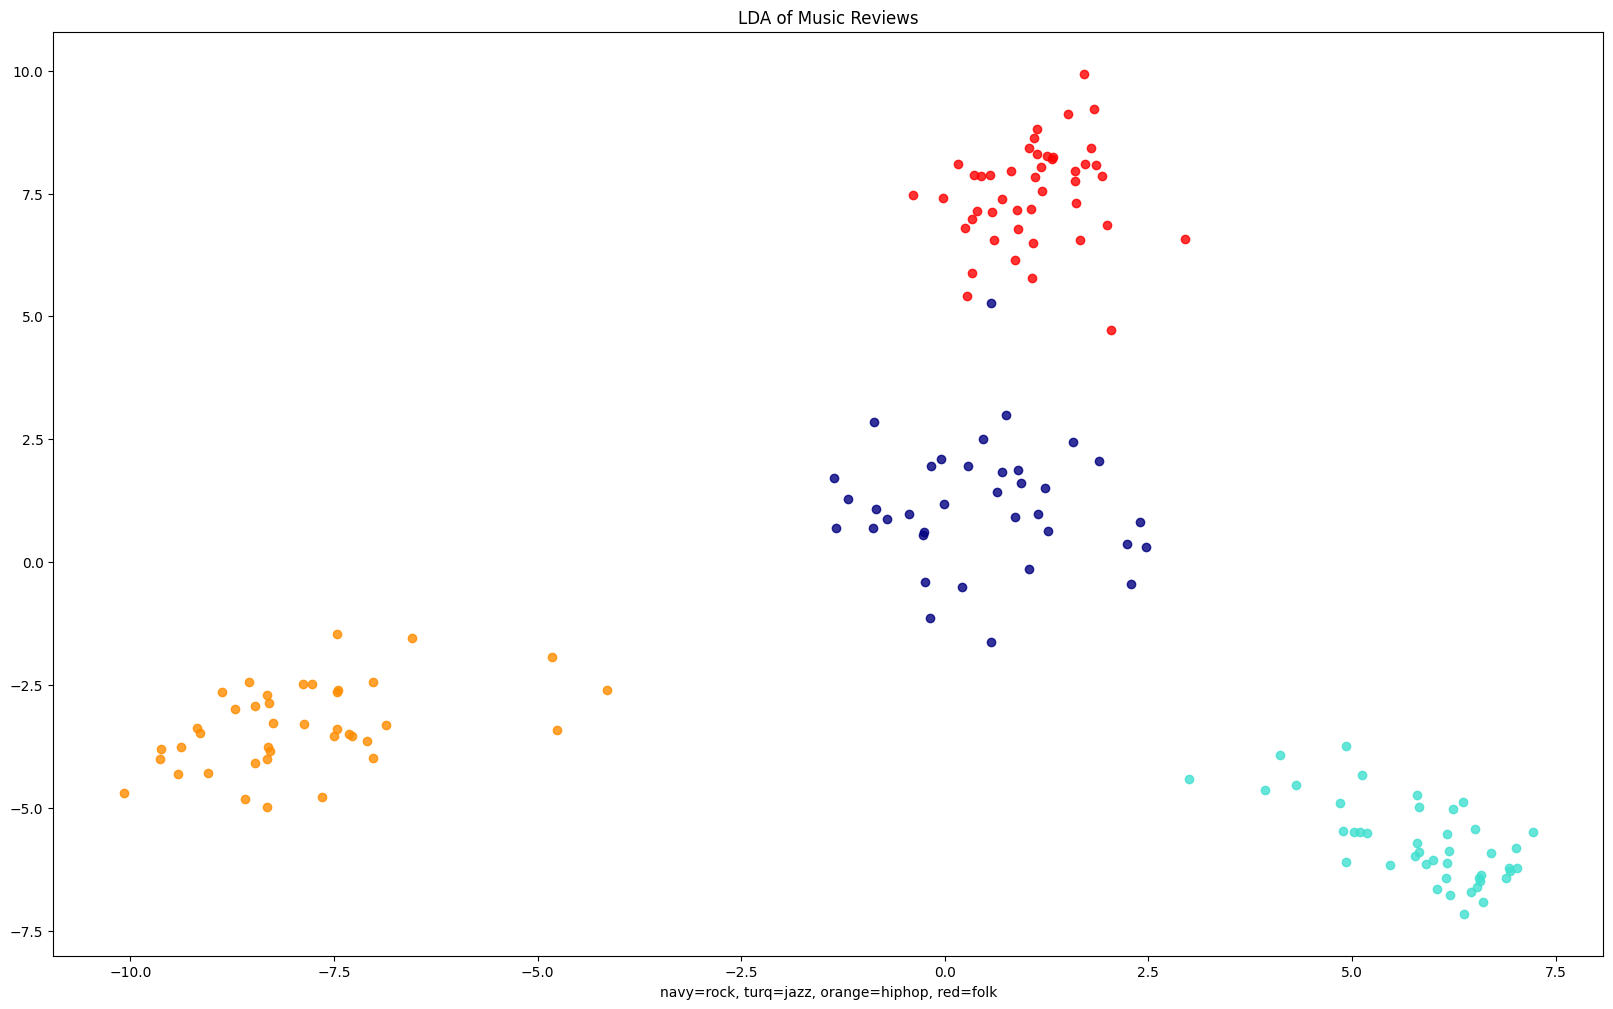

In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'red']
lw = 2

plt.figure(figsize=(20,12))
for color, i in zip(colors, [0, 1, 2, 3]):
    plt.scatter(model12[Y == i, 1], model12[Y == i, 0], alpha=.8, color=color)
plt.title('LDA of Music Reviews')
plt.xlabel('navy=rock, turq=jazz, orange=hiphop, red=folk')

plt.show()

<Figure size 640x480 with 0 Axes>

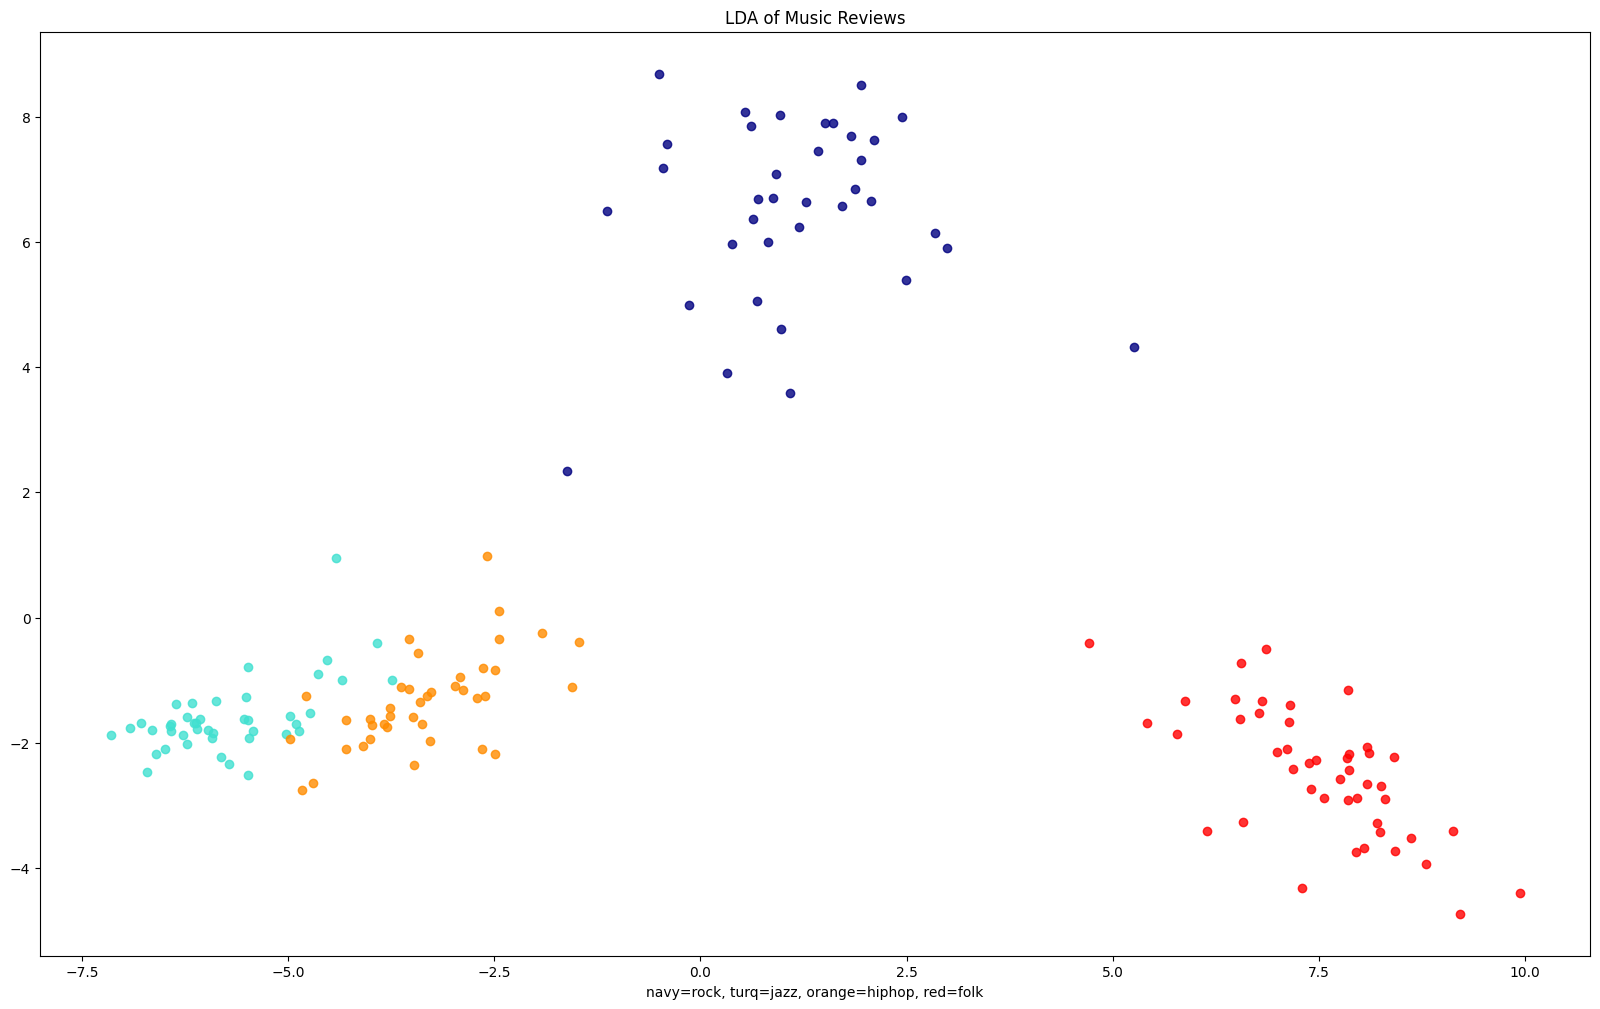

In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'red']
lw = 2

plt.figure(figsize=(20,12))
for color, i in zip(colors, [0, 1, 2, 3]):
    plt.scatter(model12[Y == i, 0], model12[Y == i, 2], alpha=.8, color=color)
plt.title('LDA of Music Reviews')
plt.xlabel('navy=rock, turq=jazz, orange=hiphop, red=folk')

plt.show()

<Figure size 640x480 with 0 Axes>

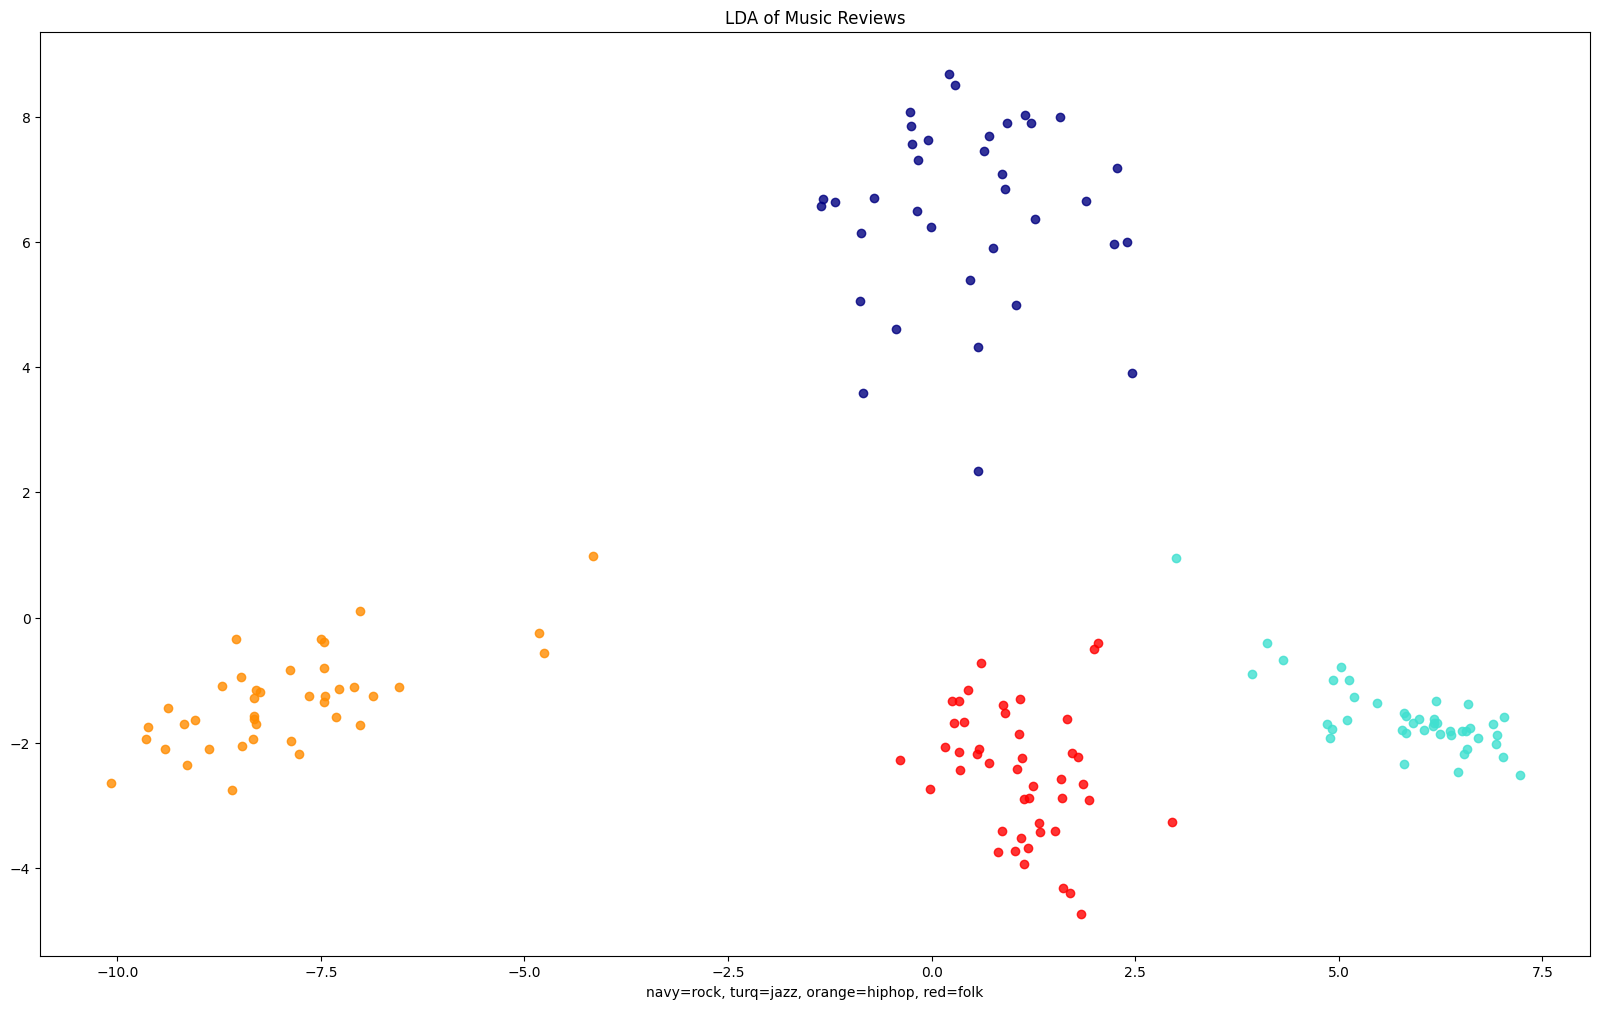

In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'red']
lw = 2

plt.figure(figsize=(20,12))
for color, i in zip(colors, [0, 1, 2, 3]):
    plt.scatter(model12[Y == i, 1], model12[Y == i, 2], alpha=.8, color=color)
plt.title('LDA of Music Reviews')
plt.xlabel('navy=rock, turq=jazz, orange=hiphop, red=folk')

plt.show()